In [14]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [15]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from datetime import datetime

In [16]:

transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [17]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [18]:
import gdown
split_ratio = 0.8 #<--- range of spliting dataset ratio {'training_size':0.8, 'testing_size':0.2}
ds = torchvision.datasets.Caltech101(root='./data',
                                     transform=transform,
                                     download=True)
train_size = int(split_ratio * len(ds))
test_size = len(ds) - train_size
training_set, validation_set = torch.utils.data.random_split(ds, [train_size, test_size])
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

Files already downloaded and verified


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [20]:
model_urls = {
     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
 }

In [21]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.maxpool(F.relu(self.bn1(self.conv1(x))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Model Selection
def ResNet18(n_C=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=n_C)

def ResNet34(n_C=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=n_C)

def ResNet50(n_C=10):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=n_C)

def ResNet101(n_C=10):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=n_C)

def ResNet152(n_C=10):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=n_C)

!pip install wget
import wget
def download_n_load_model(model, model_name):
    if model_name in model_urls:
      if not os.path.exists(f"{model_name}.pth"):
        url = model_urls[model_name]
        wget.download(url, out=f"{model_name}.pth")
      rn_model_dict=model.state_dict()
      url = model_urls[model_name]
      pretrained_dict = torch.load(f'./{model_name}.pth')
      pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in rn_model_dict) and (rn_model_dict[k].shape == pretrained_dict[k].shape)}
      rn_model_dict.update(pretrained_dict)
      model.load_state_dict(rn_model_dict)
      print(f"load checkpoint...{model_name}")
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
         MaxPool2d-5           [-1, 64, 56, 56]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
           Conv2d-13           [-1, 64, 56, 56]          36,864
       BasicBlock-14           [-1, 64,

/tmp/ipykernel_36/3651845566.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(f'./{model_name}.pth')
/opt/conda/lib/python3.10/site-package

Epochs 1   train loss 3.51644 train acc 0.26264 validate loss 2.87108 validate acc 0.37846
--------------------------------------------------------------------------------
Epochs 2   train loss 2.49118 train acc 0.42919 validate loss 2.18010 validate acc 0.49654
--------------------------------------------------------------------------------
Epochs 3   train loss 1.88406 train acc 0.54805 validate loss 1.86925 validate acc 0.55357
--------------------------------------------------------------------------------
Epochs 4   train loss 1.41200 train acc 0.63939 validate loss 1.58600 validate acc 0.60829
--------------------------------------------------------------------------------
Epochs 5   train loss 1.07646 train acc 0.71618 validate loss 1.31037 validate acc 0.68664
--------------------------------------------------------------------------------
Epochs 6   train loss 0.80424 train acc 0.78764 validate loss 1.20758 validate acc 0.70565
-------------------------------------------------

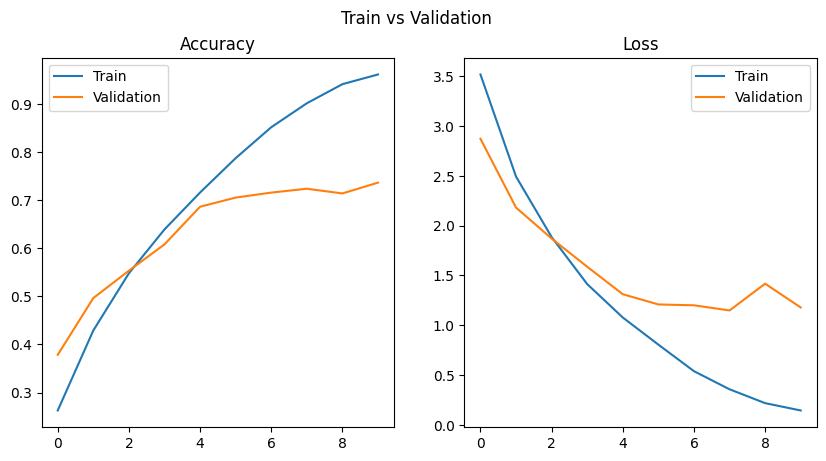

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18(n_C=101)
model= nn.DataParallel(model)
model.to(device)
summary(model, (3, 224, 224))

download_n_load_model(model, 'resnet18')

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_number = 0

EPOCHS = 10
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_accelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_pretrainedmodel.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")
plot_graph(training_logs)